In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import sys
import os

sys.path.append('/dfs/scratch0/vschen/metal')
os.environ['METALHOME'] = '/dfs/scratch0/vschen/metal'

## Data Generation

data_seed: 123


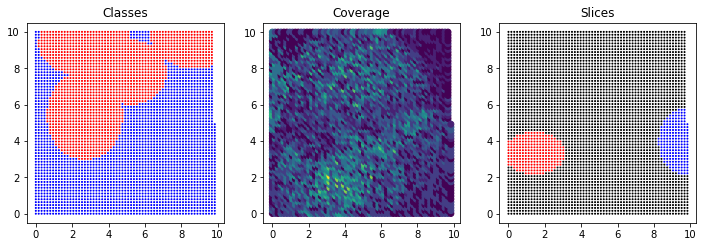

In [16]:
import numpy as np
from torch.utils.data import DataLoader

from metal.utils import SlicingDataset
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset
from metal.utils import split_data

K = 2
M = 20
N = 4000
NUM_SLICES = 2
BATCHSIZE = 32
UNIPOLAR = True
# DATA_SEED = np.random.randint(1e6)
DATA_SEED = 123
print(f"data_seed: {DATA_SEED}")

Z_kwargs = {'num_slices': NUM_SLICES}
L, X, Y, Z, _ = generate_dataset(K, M, N, 
                                 Z_kwargs=Z_kwargs,
                                 unipolar=UNIPOLAR,
                                 slice_source="maxmin",
                                 seed=DATA_SEED)

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

## LabelModel

In [17]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Ys[0] = Y_train_ps

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.692

In [18]:
import torch
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=BATCHSIZE,
    shuffle=True
)

dev_loader = DataLoader(SlicingDataset(Xs[1], Ls_tensors[1], Ys[1]))

test_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))

## SliceMaster

In [23]:
# Define custom metrics
from metal.metrics import accuracy_score
from metal.utils import convert_labels

def calc_heads_acc(model, dataloader):
    X, L, Y = dataloader.dataset.data
    L_probs, Y_off_probs, Y_on_probs = model.predict_all_proba(X)

    if model.indicator:
        L = L.clone()
        L[L == 2] = 1
    else:
        raise NotImplemented("Cannot evaluate L predictions if model.indicator=False")
    
    Y_off_preds = convert_labels(np.round(Y_off_probs[:, 0]), "onezero", "categorical")
    Y_on_preds = convert_labels(np.round(Y_on_probs[:, 0]), "onezero", "categorical")
    metrics = {}    
    
    metrics = {
        "L_acc": accuracy_score(L.flatten(), np.round(L_probs).flatten()),
        "Y_off_acc": accuracy_score(Y, Y_off_preds),
        "Y_on_acc": accuracy_score(Y, Y_on_preds),     
    }
    
    return metrics

def calc_slice_acc(model, dataloader):
    import pdb; pdb.set_trace()
    model.warn_once("Slice accuracies currently only work for valid set!")
    X, L, Y = dataloader.dataset.data
    Y_preds = model.predict(X)

    metrics = {}
    for s in range(1, NUM_SLICES + 1):
        inds = [i for i, e in enumerate(Zs[1]) if e == s]
        X_slice = X[inds]
        Y_slice = Y[inds]
        Y_preds_slice = Y_preds[inds]
        acc = model.score((X_slice, None, Y_slice), verbose=False)
        metrics[f"slice_{s}"] = acc
    return metrics

In [24]:
import os

# MODEL_SEED = np.random.randint(1e6)
MODEL_SEED = 123
print(f"model_seed: {MODEL_SEED}")

RUN_NAME = f"{DATA_SEED}_{MODEL_SEED}_SM"

em_config = {
    "layer_out_dims": [2, 5, 5, 2],
    "verbose": False,
#     "seed": MODEL_SEED,
}

sm_config = {
    "L_weight": 0.1,
    "Y_off_weight": 0.1,
    "vanilla": False,
    "online_head": True,
    "indicator": True,
    "mask_abstains": False,
    "verbose": True,
}

train_kwargs = {
    "n_epochs": 40,
    "lr": 0.001,
    "l2": 0.0,
    "log_unit": "epochs",
#     "log_train_metrics_func": None,
#     "log_train_metrics": ["loss"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": [calc_slice_acc, calc_heads_acc],
    "log_valid_metrics": ["L_acc", "Y_off_acc", "Y_on_acc"],
    "checkpoint": True,
    "checkpoint_metric": "Y_on_acc",
    "writer": "tensorboard",
    "log_dir": f"{os.environ['METALHOME']}/tensorboard/RUN_NAME/",
    "run_name": RUN_NAME,
}

model_seed: 123


In [25]:
from collections import defaultdict
history = defaultdict(list)

In [26]:
from metal.end_model import EndModel
from metal.contrib.slicing.slice_model import SliceMaster
from metal.contrib.slicing.experiment_utils import eval_model

for i in range(20):
    base_model = EndModel(**em_config)
    model = SliceMaster(base_model, m=Ls[0].shape[1], **sm_config)
    model.train_model(train_loader, valid_data=dev_loader, **train_kwargs)
    # model.score(test_loader)
    # calc_slice_accuracy(model, test_loader)
    results = eval_model(model, test_loader, verbose=False)
    history['SM'].append(results)

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=20, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=5, out_features=1, bias=True)
)

> <ipython-input-23-6c6816060d9b>(29)calc_slice_acc()
-> model.warn_once("Slice accuracies currently only work for valid set!")
(Pdb) warn_once
*** NameError: name 'warn_once' is not defined
(Pdb) model
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f17dc630db0>
Traceback (most recent call last):
  File "/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


BdbQuit: 

In [10]:
import os

# MODEL_SEED = np.random.randint(1e6)
MODEL_SEED = 123
print(f"model_seed: {MODEL_SEED}")

RUN_NAME = f"{DATA_SEED}_{MODEL_SEED}_EM"

em_config = {
    "layer_out_dims": [2, 5, 5, 2],
    "verbose": False,
#     "seed": MODEL_SEED,
}

sm_config = {
    "L_weight": 0.1,
    "Y_off_weight": 0.1,
    "vanilla": True,
    "online_head": False,
    "indicator": True,
    "mask_abstains": False,
    "verbose": True,
}

train_kwargs = {
    "n_epochs": 40,
    "lr": 0.001,
    "l2": 1e-5,
    "log_unit": "epochs",
#     "log_train_metrics_func": None,
#     "log_train_metrics": ["loss"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": [calc_slice_acc],
    "log_valid_metrics": ["accuracy"],
    "checkpoint": True,
    "checkpoint_metric": "accuracy",
    "writer": "tensorboard",
    "log_dir": f"{os.environ['METALHOME']}/tensorboard/RUN_NAME/",
    "run_name": RUN_NAME,
}

model_seed: 123


In [11]:
from metal.end_model import EndModel
from metal.contrib.slicing.slice_model import SliceMaster
from metal.contrib.slicing.experiment_utils import eval_model

for i in range(20):
    base_model = EndModel(**em_config)
    model = SliceMaster(base_model, m=Ls[0].shape[1], **sm_config)
    model.train_model(train_loader, valid_data=dev_loader, **train_kwargs)
    # model.score(test_loader)
    # calc_slice_accuracy(model, test_loader)
    results = eval_model(model, test_loader, verbose=False)
    history['EM'].append(results)

Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=23.815] VALID:[slice_1=0.426, slice_2=0.000, accuracy=0.410]
Saving model at iteration 1 with best score 0.410
[2 epo]: TRAIN:[loss=22.502] VALID:[slice_1=0.426, slice_2=0.000, accuracy=0.410]
[3 epo]: TRAIN:[loss=22.146] VALID:[slice_1=0.426, slice_2=0.000, accuracy=0.470]
Saving model at iteration 3 with best score 0.470
[4 epo]: TRAIN:[loss=21.949] VALID:[slice_1=0.607, slice_2=0.833, accuracy=0.793]
Saving model at iteration 4 with best score 0.793
[5 epo]: TRAIN:[loss=21.926] VALID:[slice_1=0.656, slice_2=0.810

[35 epo]: TRAIN:[loss=21.864] VALID:[slice_1=0.721, slice_2=0.857, accuracy=0.815]
Saving model at iteration 35 with best score 0.815
[36 epo]: TRAIN:[loss=21.862] VALID:[slice_1=0.705, slice_2=0.333, accuracy=0.789]
[37 epo]: TRAIN:[loss=21.860] VALID:[slice_1=0.738, slice_2=0.333, accuracy=0.790]
[38 epo]: TRAIN:[loss=21.859] VALID:[slice_1=0.738, slice_2=0.595, accuracy=0.806]
[39 epo]: TRAIN:[loss=21.859] VALID:[slice_1=0.721, slice_2=0.810, accuracy=0.813]
[40 epo]: TRAIN:[loss=21.860] VALID:[slice_1=0.721, slice_2=0.619, accuracy=0.805]
Restoring best model from iteration 35 with score 0.815
Finished Training
Accuracy: 0.815
        y=1    y=2   
 l=1    356    54    
 l=2    131    459   

SUMMARY (accuracies):
All: 0.816
Slice 0: 0.8162344983089064
Slice 1: 0.7708333333333334
Slice 2: 0.8461538461538461
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linea

[30 epo]: TRAIN:[loss=21.870] VALID:[slice_1=0.770, slice_2=0.595, accuracy=0.803]
[31 epo]: TRAIN:[loss=21.866] VALID:[slice_1=0.754, slice_2=0.500, accuracy=0.799]
[32 epo]: TRAIN:[loss=21.866] VALID:[slice_1=0.721, slice_2=0.452, accuracy=0.791]
[33 epo]: TRAIN:[loss=21.868] VALID:[slice_1=0.869, slice_2=0.738, accuracy=0.819]
[34 epo]: TRAIN:[loss=21.867] VALID:[slice_1=0.852, slice_2=0.714, accuracy=0.817]
[35 epo]: TRAIN:[loss=21.866] VALID:[slice_1=0.803, slice_2=0.667, accuracy=0.814]
[36 epo]: TRAIN:[loss=21.865] VALID:[slice_1=0.836, slice_2=0.762, accuracy=0.825]
[37 epo]: TRAIN:[loss=21.865] VALID:[slice_1=0.820, slice_2=0.738, accuracy=0.819]
[38 epo]: TRAIN:[loss=21.864] VALID:[slice_1=0.738, slice_2=0.738, accuracy=0.815]
[39 epo]: TRAIN:[loss=21.863] VALID:[slice_1=0.721, slice_2=0.429, accuracy=0.793]
[40 epo]: TRAIN:[loss=21.864] VALID:[slice_1=0.721, slice_2=0.429, accuracy=0.785]
Restoring best model from iteration 14 with score 0.840
Finished Training
Accuracy: 0.8

[25 epo]: TRAIN:[loss=21.885] VALID:[slice_1=0.639, slice_2=0.738, accuracy=0.802]
[26 epo]: TRAIN:[loss=21.884] VALID:[slice_1=0.639, slice_2=0.738, accuracy=0.808]
[27 epo]: TRAIN:[loss=21.884] VALID:[slice_1=0.639, slice_2=0.810, accuracy=0.816]
[28 epo]: TRAIN:[loss=21.882] VALID:[slice_1=0.607, slice_2=0.738, accuracy=0.803]
[29 epo]: TRAIN:[loss=21.881] VALID:[slice_1=0.607, slice_2=0.738, accuracy=0.801]
[30 epo]: TRAIN:[loss=21.880] VALID:[slice_1=0.623, slice_2=0.738, accuracy=0.803]
[31 epo]: TRAIN:[loss=21.880] VALID:[slice_1=0.607, slice_2=0.738, accuracy=0.800]
[32 epo]: TRAIN:[loss=21.880] VALID:[slice_1=0.623, slice_2=0.762, accuracy=0.811]
[33 epo]: TRAIN:[loss=21.882] VALID:[slice_1=0.590, slice_2=0.548, accuracy=0.787]
[34 epo]: TRAIN:[loss=21.881] VALID:[slice_1=0.623, slice_2=0.833, accuracy=0.818]
[35 epo]: TRAIN:[loss=21.879] VALID:[slice_1=0.607, slice_2=0.833, accuracy=0.822]
[36 epo]: TRAIN:[loss=21.879] VALID:[slice_1=0.574, slice_2=0.667, accuracy=0.795]
[37 

[17 epo]: TRAIN:[loss=21.896] VALID:[slice_1=0.852, slice_2=0.857, accuracy=0.830]
Saving model at iteration 17 with best score 0.830
[18 epo]: TRAIN:[loss=21.894] VALID:[slice_1=0.852, slice_2=0.857, accuracy=0.826]
[19 epo]: TRAIN:[loss=21.896] VALID:[slice_1=0.852, slice_2=0.857, accuracy=0.832]
Saving model at iteration 19 with best score 0.832
[20 epo]: TRAIN:[loss=21.895] VALID:[slice_1=0.803, slice_2=0.857, accuracy=0.825]
[21 epo]: TRAIN:[loss=21.894] VALID:[slice_1=0.770, slice_2=0.833, accuracy=0.822]
[22 epo]: TRAIN:[loss=21.895] VALID:[slice_1=0.705, slice_2=0.810, accuracy=0.816]
[23 epo]: TRAIN:[loss=21.893] VALID:[slice_1=0.770, slice_2=0.810, accuracy=0.819]
[24 epo]: TRAIN:[loss=21.892] VALID:[slice_1=0.770, slice_2=0.810, accuracy=0.815]
[25 epo]: TRAIN:[loss=21.893] VALID:[slice_1=0.738, slice_2=0.810, accuracy=0.814]
[26 epo]: TRAIN:[loss=21.891] VALID:[slice_1=0.820, slice_2=0.881, accuracy=0.829]
[27 epo]: TRAIN:[loss=21.892] VALID:[slice_1=0.803, slice_2=0.881, a

[9 epo]: TRAIN:[loss=21.913] VALID:[slice_1=0.918, slice_2=0.595, accuracy=0.807]
[10 epo]: TRAIN:[loss=21.913] VALID:[slice_1=0.836, slice_2=0.810, accuracy=0.824]
Saving model at iteration 10 with best score 0.824
[11 epo]: TRAIN:[loss=21.915] VALID:[slice_1=0.918, slice_2=0.524, accuracy=0.802]
[12 epo]: TRAIN:[loss=21.914] VALID:[slice_1=0.918, slice_2=0.524, accuracy=0.803]
[13 epo]: TRAIN:[loss=21.913] VALID:[slice_1=0.918, slice_2=0.714, accuracy=0.820]
[14 epo]: TRAIN:[loss=21.914] VALID:[slice_1=0.885, slice_2=0.786, accuracy=0.824]
[15 epo]: TRAIN:[loss=21.913] VALID:[slice_1=0.918, slice_2=0.524, accuracy=0.805]
[16 epo]: TRAIN:[loss=21.913] VALID:[slice_1=0.918, slice_2=0.690, accuracy=0.817]
[17 epo]: TRAIN:[loss=21.910] VALID:[slice_1=0.754, slice_2=1.000, accuracy=0.857]
Saving model at iteration 17 with best score 0.857
[18 epo]: TRAIN:[loss=21.911] VALID:[slice_1=0.918, slice_2=0.643, accuracy=0.814]
[19 epo]: TRAIN:[loss=21.915] VALID:[slice_1=0.852, slice_2=0.833, ac

[1 epo]: TRAIN:[loss=23.259] VALID:[slice_1=0.213, slice_2=1.000, accuracy=0.474]
Saving model at iteration 1 with best score 0.474
[2 epo]: TRAIN:[loss=22.315] VALID:[slice_1=0.426, slice_2=1.000, accuracy=0.617]
Saving model at iteration 2 with best score 0.617
[3 epo]: TRAIN:[loss=22.126] VALID:[slice_1=0.426, slice_2=1.000, accuracy=0.622]
Saving model at iteration 3 with best score 0.622
[4 epo]: TRAIN:[loss=22.060] VALID:[slice_1=0.426, slice_2=1.000, accuracy=0.607]
[5 epo]: TRAIN:[loss=22.031] VALID:[slice_1=0.426, slice_2=1.000, accuracy=0.622]
[6 epo]: TRAIN:[loss=22.018] VALID:[slice_1=0.426, slice_2=1.000, accuracy=0.652]
Saving model at iteration 6 with best score 0.652
[7 epo]: TRAIN:[loss=22.010] VALID:[slice_1=0.426, slice_2=1.000, accuracy=0.666]
Saving model at iteration 7 with best score 0.666
[8 epo]: TRAIN:[loss=22.004] VALID:[slice_1=0.426, slice_2=1.000, accuracy=0.667]
Saving model at iteration 8 with best score 0.667
[9 epo]: TRAIN:[loss=21.998] VALID:[slice_1=

[40 epo]: TRAIN:[loss=21.875] VALID:[slice_1=0.623, slice_2=0.738, accuracy=0.818]
Restoring best model from iteration 21 with score 0.858
Finished Training
Accuracy: 0.858
        y=1    y=2   
 l=1    394    16    
 l=2    126    464   

SUMMARY (accuracies):
All: 0.847
Slice 0: 0.8354002254791432
Slice 1: 0.8541666666666666
Slice 2: 1.0
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=23.983] VALID:[slice_1=0.574, slice_2=1.000, accuracy=0.590]
Saving model at iteration 1 with best score 0.590
[2 epo]: TRAIN:[loss=22.581] VALID:[slice_1=0.574, slice_2=1.000, ac

[32 epo]: TRAIN:[loss=21.890] VALID:[slice_1=0.738, slice_2=0.810, accuracy=0.819]
[33 epo]: TRAIN:[loss=21.888] VALID:[slice_1=0.623, slice_2=0.690, accuracy=0.789]
[34 epo]: TRAIN:[loss=21.888] VALID:[slice_1=0.607, slice_2=0.714, accuracy=0.792]
[35 epo]: TRAIN:[loss=21.887] VALID:[slice_1=0.705, slice_2=0.595, accuracy=0.813]
[36 epo]: TRAIN:[loss=21.886] VALID:[slice_1=0.656, slice_2=0.714, accuracy=0.813]
[37 epo]: TRAIN:[loss=21.884] VALID:[slice_1=0.754, slice_2=0.929, accuracy=0.851]
Saving model at iteration 37 with best score 0.851
[38 epo]: TRAIN:[loss=21.884] VALID:[slice_1=0.656, slice_2=0.524, accuracy=0.807]
[39 epo]: TRAIN:[loss=21.879] VALID:[slice_1=0.590, slice_2=0.167, accuracy=0.766]
[40 epo]: TRAIN:[loss=21.883] VALID:[slice_1=0.590, slice_2=0.429, accuracy=0.792]
Restoring best model from iteration 37 with score 0.851
Finished Training
Accuracy: 0.851
        y=1    y=2   
 l=1    393    17    
 l=2    132    458   

SUMMARY (accuracies):
All: 0.842
Slice 0: 0.8

[21 epo]: TRAIN:[loss=21.925] VALID:[slice_1=0.459, slice_2=0.857, accuracy=0.772]
Saving model at iteration 21 with best score 0.772
[22 epo]: TRAIN:[loss=21.922] VALID:[slice_1=0.508, slice_2=0.929, accuracy=0.805]
Saving model at iteration 22 with best score 0.805
[23 epo]: TRAIN:[loss=21.922] VALID:[slice_1=0.492, slice_2=0.810, accuracy=0.785]
[24 epo]: TRAIN:[loss=21.919] VALID:[slice_1=0.508, slice_2=0.857, accuracy=0.795]
[25 epo]: TRAIN:[loss=21.918] VALID:[slice_1=0.525, slice_2=0.810, accuracy=0.792]
[26 epo]: TRAIN:[loss=21.916] VALID:[slice_1=0.525, slice_2=0.810, accuracy=0.793]
[27 epo]: TRAIN:[loss=21.915] VALID:[slice_1=0.590, slice_2=0.857, accuracy=0.808]
Saving model at iteration 27 with best score 0.808
[28 epo]: TRAIN:[loss=21.912] VALID:[slice_1=0.607, slice_2=0.857, accuracy=0.810]
Saving model at iteration 28 with best score 0.810
[29 epo]: TRAIN:[loss=21.909] VALID:[slice_1=0.623, slice_2=0.857, accuracy=0.811]
Saving model at iteration 29 with best score 0.81

[9 epo]: TRAIN:[loss=21.912] VALID:[slice_1=0.820, slice_2=0.619, accuracy=0.815]
Saving model at iteration 9 with best score 0.815
[10 epo]: TRAIN:[loss=21.910] VALID:[slice_1=0.869, slice_2=0.595, accuracy=0.818]
Saving model at iteration 10 with best score 0.818
[11 epo]: TRAIN:[loss=21.907] VALID:[slice_1=0.803, slice_2=0.738, accuracy=0.820]
Saving model at iteration 11 with best score 0.820
[12 epo]: TRAIN:[loss=21.902] VALID:[slice_1=0.885, slice_2=0.643, accuracy=0.824]
Saving model at iteration 12 with best score 0.824
[13 epo]: TRAIN:[loss=21.902] VALID:[slice_1=0.820, slice_2=0.738, accuracy=0.817]
[14 epo]: TRAIN:[loss=21.901] VALID:[slice_1=0.836, slice_2=0.738, accuracy=0.815]
[15 epo]: TRAIN:[loss=21.899] VALID:[slice_1=0.820, slice_2=0.738, accuracy=0.812]
[16 epo]: TRAIN:[loss=21.898] VALID:[slice_1=0.869, slice_2=0.738, accuracy=0.818]
[17 epo]: TRAIN:[loss=21.896] VALID:[slice_1=0.836, slice_2=0.714, accuracy=0.817]
[18 epo]: TRAIN:[loss=21.895] VALID:[slice_1=0.820,

In [30]:
history

defaultdict(list, {})

In [ ]:
from metal.contrib.slicing.experiment_utils import parse_history

# print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, 4)
df

In [13]:
# """Are we recovering the Ls?"""

# L_probs = model.predict_L_proba(torch.Tensor(Xs[1]))
# if sm_config["indicator"]:
#     L_preds = np.round(L_probs)
#     L_preds[L_preds == 0] = 2

#     # 0 is negative, {1,2} are positive
#     L_gold = np.asarray(Ls[1].todense())
#     L_gold[L_gold != 0] = 1
#     L_gold[L_gold == 0] = 2

# print()
# for j in [0,1,2]:
#     score = accuracy_score(L_gold[:,j], L_preds[:,j], ignore_in_gold=[0])
#     print(f"LF_{j}: {score}")